Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [598]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import nan
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

students = pd.read_csv('stud_math.csv')
students = students.rename(columns={'studytime, granular': 'studytime_granular'}) # преобразуем название столбца для удобства

stud = students.copy()
stud.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0  at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0  at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0  at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0   health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0    other    other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother         2.0        2.0       0.0       yes     no   no   
1  course   father         1.0        2.0       0.0        no    yes   no   
2   other   mother         1.0        2.0       3.0       yes     no  NaN   
3    home   mother         1.0        3.0       0.0        no    yes  yes   
4    home   father         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime_granular higher internet romantic  famrel  \
0         no     yes                -6.0    yes      NaN       no     4.0   
1         no      no                -6.0    yes      yes       no     5.0   
2         no     yes                -6.0    yes      yes      NaN     4.0   
3        yes     yes                -9.0    yes      yes      yes     3.0   
4         no     yes                -6.0    yes       no       no     4.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0

In [599]:
stud.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  395.000000  392.000000  371.000000  367.000000  388.000000  373.000000   
mean    16.696203    2.750000    2.614555    1.438692    2.038660    0.337802   
std      1.276043    1.098127    2.228732    0.694181    0.842078    0.743135   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000   40.000000    4.000000    4.000000    3.000000   

       studytime_granular      famrel    freetime       goout      health  \
count          388.000000  368.000000  384.000000  387.000000  380.000000   
mean            -6.115979    3.937500    3.231771    3.105943    3.531579   
std              2.526235    0.927277    0.993940    1.115896    1.396019   
min            -12.000000   -1.000000    1.000000    1.000000    1.000000   
25%             -6.000000    4.000000    3.000000    2.000000    3.000000   
50%             -6.000000    4.000000    3.000000    3.000000    4.000000   
75%             -3.000000    5.000000    4.000000    4.000000    5.000000   
max             -3.000000    5.000000    5.000000    5.000000    5.000000   

         absences       score  
count  383.000000  389.000000  
mean     7.279373   52.262211  
std     23.465197   22.919022  
min      0.000000    0.000000  
25%      0.000000   40.000000  
50%      4.000000   55.000000  
75%      8.000000   70.000000  
max    385.000000  100.000000

In [600]:
stud.info() # как видно, много пропусков в разных столбцах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              395 non-null    object 
 1   sex                 395 non-null    object 
 2   age                 395 non-null    int64  
 3   address             378 non-null    object 
 4   famsize             368 non-null    object 
 5   Pstatus             350 non-null    object 
 6   Medu                392 non-null    float64
 7   Fedu                371 non-null    float64
 8   Mjob                376 non-null    object 
 9   Fjob                359 non-null    object 
 10  reason              378 non-null    object 
 11  guardian            364 non-null    object 
 12  traveltime          367 non-null    float64
 13  studytime           388 non-null    float64
 14  failures            373 non-null    float64
 15  schoolsup           386 non-null    object 
 16  famsup  

In [601]:
def isnan(value): # проверка на NaN
    try:
        return math.isnan(float(value))
    except:
        return False

def filterUndefined(value): # заменяем не опознанные значения на None
    return None if isnan(value) else None if value == '' else value

def noneCount(df, value):
    return len(df[df[value].isnull()])

In [602]:
print('Уникальные значения до замены', students.address.unique())
stud.address = students.address.apply(filterUndefined)
print('Уникальные значения после замены', stud.address.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"address"', noneCount(stud, 'address')))

Уникальные значения до замены ['U' nan 'R']
Уникальные значения после замены ['U' None 'R']
Количество пропущенных значений в столбце "address": 17


In [603]:
print('Уникальные значения до замены', students.famsize.unique())
stud.famsize = students.famsize.apply(filterUndefined)
print('Уникальные значения после замены', stud.famsize.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"famsize"', noneCount(stud, 'famsize')))

Уникальные значения до замены [nan 'GT3' 'LE3']
Уникальные значения после замены [None 'GT3' 'LE3']
Количество пропущенных значений в столбце "famsize": 27


In [604]:
print('Уникальные значения до замены', students.Pstatus.unique())
stud.Pstatus = students.Pstatus.apply(filterUndefined)
print('Уникальные значения после замены', stud.Pstatus.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"Pstatus"', noneCount(stud, 'Pstatus')))

Уникальные значения до замены ['A' nan 'T']
Уникальные значения после замены ['A' None 'T']
Количество пропущенных значений в столбце "Pstatus": 45


In [605]:
display(students.Medu.value_counts()) # в Medu по всей вероятности выбросов нет
display(students.Fedu.value_counts()) # в Fedu есть выброс, мы его отфильтруем

IQR = students.Fedu.quantile(0.75) - students.Fedu.quantile(0.25)
perc75 = students.Fedu.quantile(0.75)
stud = stud.loc[stud.Fedu.between(0, perc75 + 1.5*IQR)]
display(stud.Fedu.value_counts()) # выброс был исключен

print('Количество пропущенных значений в столбце {}: {}'.format('"Medu"', noneCount(stud, 'Medu')))
print('Количество пропущенных значений в столбце {}: {}'.format('"Fedu"', noneCount(students, 'Fedu')))

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64

2.0    106
3.0     96
4.0     88
1.0     78
0.0      2
Name: Fedu, dtype: int64

Количество пропущенных значений в столбце "Medu": 3
Количество пропущенных значений в столбце "Fedu": 24


In [606]:
print('Уникальные значения до замены', students.Mjob.unique())
stud.Mjob = students.Mjob.apply(filterUndefined)
print('Уникальные значения после замены', stud.Mjob.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"Mjob"', noneCount(stud, 'Mjob')))

Уникальные значения до замены ['at_home' 'health' 'other' 'services' 'teacher' nan]
Уникальные значения после замены ['at_home' 'health' 'other' 'services' 'teacher' None]
Количество пропущенных значений в столбце "Mjob": 19


In [607]:
print('Уникальные значения до замены', students.Fjob.unique())
stud.Fjob = students.Fjob.apply(filterUndefined)
print('Уникальные значения после замены', stud.Fjob.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"Fjob"', noneCount(stud, 'Fjob')))

Уникальные значения до замены ['teacher' 'other' nan 'health' 'services' 'at_home']
Уникальные значения после замены ['teacher' 'other' None 'health' 'services' 'at_home']
Количество пропущенных значений в столбце "Fjob": 34


In [608]:
print('Уникальные значения до замены', students.reason.unique())
stud.reason = students.reason.apply(filterUndefined)
print('Уникальные значения после замены', stud.reason.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"reason"', noneCount(stud, 'reason')))

Уникальные значения до замены ['course' 'other' 'home' 'reputation' nan]
Уникальные значения после замены ['course' 'other' 'home' 'reputation' None]
Количество пропущенных значений в столбце "reason": 16


In [609]:
print('Уникальные значения до замены', students.guardian.unique())
stud.guardian = students.guardian.apply(filterUndefined)
print('Уникальные значения после замены', stud.guardian.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"guardian"', noneCount(stud, 'guardian')))

Уникальные значения до замены ['mother' 'father' 'other' nan]
Уникальные значения после замены ['mother' 'father' 'other' None]
Количество пропущенных значений в столбце "guardian": 30


In [610]:
display(students.traveltime.value_counts()) # в traveltime по всей вероятности выбросов нет
print('Количество пропущенных значений в столбце {}: {}'.format('"traveltime"', noneCount(stud, 'traveltime')))

1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64

Количество пропущенных значений в столбце "traveltime": 25


In [611]:
display(students.studytime.value_counts()) # в studytime по всей вероятности выбросов нет
print('Количество пропущенных значений в столбце {}: {}'.format('"studytime"', noneCount(stud, 'studytime')))

2.0    194
1.0    103
3.0     64
4.0     27
Name: studytime, dtype: int64

Количество пропущенных значений в столбце "studytime": 7


In [612]:
display(students.failures.value_counts()) # в failures по всей вероятности выбросов нет
print('Количество пропущенных значений в столбце {}: {}'.format('"failures"', noneCount(stud, 'failures')))

0.0    293
1.0     49
2.0     16
3.0     15
Name: failures, dtype: int64

Количество пропущенных значений в столбце "failures": 19


In [613]:
print('Уникальные значения до замены', students.schoolsup.unique())
stud.schoolsup = students.schoolsup.apply(filterUndefined)
print('Уникальные значения после замены', stud.schoolsup.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"schoolsup"', noneCount(stud, 'schoolsup')))

Уникальные значения до замены ['yes' 'no' nan]
Уникальные значения после замены ['yes' 'no' None]
Количество пропущенных значений в столбце "schoolsup": 9


In [614]:
print('Уникальные значения до замены', students.famsup.unique())
stud.famsup = students.famsup.apply(filterUndefined)
print('Уникальные значения после замены', stud.famsup.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"famsup"', noneCount(stud, 'famsup')))

Уникальные значения до замены ['no' 'yes' nan]
Уникальные значения после замены ['no' 'yes' None]
Количество пропущенных значений в столбце "famsup": 35


In [615]:
print('Уникальные значения до замены', students.paid.unique())
stud.paid = students.paid.apply(filterUndefined)
print('Уникальные значения после замены', stud.paid.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"paid"', noneCount(stud, 'paid')))

Уникальные значения до замены ['no' nan 'yes']
Уникальные значения после замены ['no' None 'yes']
Количество пропущенных значений в столбце "paid": 37


In [616]:
print('Уникальные значения до замены', students.activities.unique())
stud.activities = students.activities.apply(filterUndefined)
print('Уникальные значения после замены', stud.activities.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"activities"', noneCount(stud, 'activities')))

Уникальные значения до замены ['no' 'yes' nan]
Уникальные значения после замены ['no' 'yes' None]
Количество пропущенных значений в столбце "activities": 14


In [617]:
print('Уникальные значения до замены', students.nursery.unique())
stud.nursery = students.nursery.apply(filterUndefined)
print('Уникальные значения после замены', stud.nursery.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"nursery"', noneCount(stud, 'nursery')))

Уникальные значения до замены ['yes' 'no' nan]
Уникальные значения после замены ['yes' 'no' None]
Количество пропущенных значений в столбце "nursery": 16


In [618]:
display(stud.studytime_granular.value_counts())
print('Количество пропущенных значений в столбце {}: {}'.format('"studytime_granular"', noneCount(stud, 'studytime_granular')))

-6.0     182
-3.0      98
-9.0      58
-12.0     25
Name: studytime_granular, dtype: int64

Количество пропущенных значений в столбце "studytime_granular": 7


In [619]:
print('Уникальные значения до замены', students.higher.unique())
stud.higher = students.higher.apply(filterUndefined)
print('Уникальные значения после замены', stud.higher.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"higher"', noneCount(stud, 'higher')))

Уникальные значения до замены ['yes' nan 'no']
Уникальные значения после замены ['yes' None 'no']
Количество пропущенных значений в столбце "higher": 18


In [620]:
print('Уникальные значения до замены', students.internet.unique())
stud.internet = students.internet.apply(filterUndefined)
print('Уникальные значения после замены', stud.internet.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"internet"', noneCount(stud, 'internet')))

Уникальные значения до замены [nan 'yes' 'no']
Уникальные значения после замены [None 'yes' 'no']
Количество пропущенных значений в столбце "internet": 33


In [621]:
print('Уникальные значения до замены', students.romantic.unique())
stud.romantic = students.romantic.apply(filterUndefined)
print('Уникальные значения после замены', stud.romantic.unique())
print('Количество пропущенных значений в столбце {}: {}'.format('"romantic"', noneCount(stud, 'romantic')))

Уникальные значения до замены ['no' nan 'yes']
Уникальные значения после замены ['no' None 'yes']
Количество пропущенных значений в столбце "romantic": 28


In [622]:
display(students.famrel.value_counts()) # в famrel есть выбросы, мы их отфильтруем
stud = stud.loc[stud.famrel.between(1, 5)]
display(stud.famrel.value_counts()) # выбросы были исключены

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

4.0    168
5.0     95
3.0     59
2.0     16
1.0      7
Name: famrel, dtype: int64

In [623]:
stud.freetime.value_counts() # в freetime по всей вероятности выбросов нет

3.0    134
4.0     97
2.0     54
5.0     34
1.0     17
Name: freetime, dtype: int64

In [624]:
stud.goout.value_counts() # в goout по всей вероятности выбросов нет

3.0    115
2.0     87
4.0     71
5.0     45
1.0     19
Name: goout, dtype: int64

In [625]:
stud.health.value_counts() # в health по всей вероятности выбросов нет

5.0    111
3.0     81
4.0     58
1.0     42
2.0     40
Name: health, dtype: int64

In [626]:
display(students.absences.describe()) # в absences есть выбросы, мы их отфильтруем

IQR = stud.absences.quantile(0.75) - stud.absences.quantile(0.25)
perc25 = stud.absences.quantile(0.25)
perc75 = stud.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
stud = stud.loc[stud.absences.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
display(stud.absences.describe()) # выбросы были исключены

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


count    318.000000
mean       4.522013
std        4.840466
min        0.000000
25%        0.000000
50%        3.500000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

In [627]:
display(stud.score.describe()) # в score по всей вероятности выбросов нет
print('Количество пропущенных значений в столбце {}: {}'.format('"score"', noneCount(stud, 'score')))

count    313.000000
mean      52.124601
std       22.511546
min        0.000000
25%       45.000000
50%       55.000000
75%       65.000000
max      100.000000
Name: score, dtype: float64

Количество пропущенных значений в столбце "score": 5


In [628]:
stud.info() # данные после подготовки

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 394
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   school              318 non-null    object 
 1   sex                 318 non-null    object 
 2   age                 318 non-null    int64  
 3   address             306 non-null    object 
 4   famsize             298 non-null    object 
 5   Pstatus             283 non-null    object 
 6   Medu                315 non-null    float64
 7   Fedu                318 non-null    float64
 8   Mjob                303 non-null    object 
 9   Fjob                291 non-null    object 
 10  reason              304 non-null    object 
 11  guardian            290 non-null    object 
 12  traveltime          295 non-null    float64
 13  studytime           313 non-null    float64
 14  failures            301 non-null    float64
 15  schoolsup           309 non-null    object 
 16  famsup  

In [629]:
stud.describe() # все выбросы исключены из датасета

age        Medu        Fedu  traveltime   studytime    failures  \
count  318.000000  315.000000  318.000000  295.000000  313.000000  301.000000   
mean    16.679245    2.730159    2.484277    1.471186    2.038339    0.312292   
std      1.272474    1.108829    1.096915    0.717860    0.857732    0.740821   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    0.000000   
50%     17.000000    3.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

       studytime_granular      famrel    freetime       goout      health  \
count          313.000000  318.000000  310.000000  310.000000  305.000000   
mean            -6.115016    3.965409    3.248387    3.083871    3.498361   
std              2.573197    0.910194    0.998177    1.096950    1.374401   
min            -12.000000    1.000000    1.000000    1.000000    1.000000   
25%             -6.000000    4.000000    3.000000    2.000000    3.000000   
50%             -6.000000    4.000000    3.000000    3.000000    4.000000   
75%             -3.000000    5.000000    4.000000    4.000000    5.000000   
max             -3.000000    5.000000    5.000000    5.000000    5.000000   

         absences       score  
count  318.000000  313.000000  
mean     4.522013   52.124601  
std      4.840466   22.511546  
min      0.000000    0.000000  
25%      0.000000   45.000000  
50%      3.500000   55.000000  
75%      7.000000   65.000000  
max     20.000000  100.000000

In [689]:
corrDf = pd.DataFrame([stud.Medu, stud.Fedu, stud.score]).transpose()
display(corrDf.corr())
print('\nИз-за низкой корреляции данных между образованности родителей и оценками учеников сложно сказать что есть взаимосвязь')

Medu      Fedu     score
Medu   1.000000  0.647425  0.198240
Fedu   0.647425  1.000000  0.114211
score  0.198240  0.114211  1.000000


Из-за низкой корреляции данных между образованности родителей и оценками учеников сложно сказать что есть взаимосвязь


In [678]:
display(stud.filter(items=['sex','score']).groupby(by = ['sex']).describe())
print('\nНе смотря на то что число учениц выше чем учеников по всем показателям их оценки ниже')

score                                                    
     count       mean        std  min   25%   50%   75%    max
sex                                                           
F    165.0  49.848485  22.384012  0.0  40.0  50.0  65.0   90.0
M    148.0  54.662162  22.456778  0.0  45.0  55.0  70.0  100.0


Не смотря на то что число учениц выше чем учеников по всем показателям их оценки ниже



Показатели по средним оценкам в разрезе событий в жизни учеников не выявили большой разницы между теми кто занимался той или иной деятельностью. Исключение составляет лишь намерение получить высшее образование и средний балл у тех кто не хочет получить вышку намного ниже чем у тех кто хочет. Это может означать то что те кто не хочет учится в вузе менее заинтересованы в получении высоких оценок.




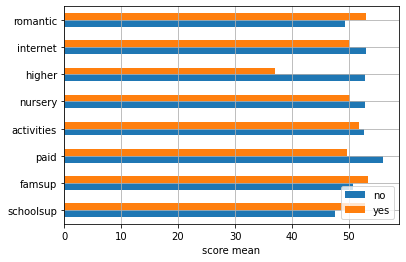

In [771]:
ssMean = stud.filter(items=['schoolsup','score']).groupby(by = ['schoolsup']).mean()
fsMean = stud.filter(items=['famsup','score']).groupby(by = ['famsup']).mean()
pMean = stud.filter(items=['paid','score']).groupby(by = ['paid']).mean()
aMean = stud.filter(items=['activities','score']).groupby(by = ['activities']).mean()
nMean = stud.filter(items=['nursery','score']).groupby(by = ['nursery']).mean()
hMean = stud.filter(items=['higher','score']).groupby(by = ['higher']).mean()
iMean = stud.filter(items=['internet','score']).groupby(by = ['internet']).mean()
rMean = stud.filter(items=['romantic','score']).groupby(by = ['romantic']).mean()

dfs = [ssMean, fsMean, pMean, aMean, nMean, hMean, iMean, rMean]
def sep(arr):
    yesItems = []
    noItems = []
    for dtFrm in arr:
        for key, value in dtFrm.items():
            yesItems.append(value['yes'])
            noItems.append(value['no'])
    return (yesItems, noItems)

filtered = sep(dfs)
index = ['schoolsup', 'famsup', 'paid',
         'activities', 'nursery', 'higher', 'internet', 'romantic']

df = pd.DataFrame({'no':filtered[0], 'yes':filtered[1]}, index=index)
ax = df.plot(grid=True, kind='barh')
ax.set_xlabel('score mean')

print('\nПоказатели по средним оценкам в разрезе событий в жизни учеников не выявили большой разницы между теми кто занимался той или иной деятельностью. Исключение составляет лишь намерение получить высшее образование и средний балл у тех кто не хочет получить вышку намного ниже чем у тех кто хочет. Это может означать то что те кто не хочет учится в вузе менее заинтересованы в получении высоких оценок.\n\n')


Ниже представлены графики некоторых условий жизни учеников которые влияют на их средние оценки. A конкретно то что средние баллы выше у тех учеников которые учатся или учились в школе GP, находятся в городе, семья состоит из менее или равно 3 чел. и родители находятся в разводе.




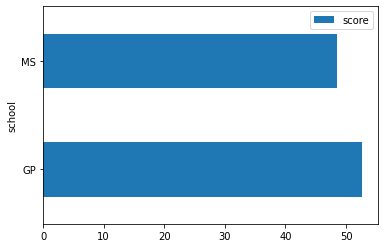

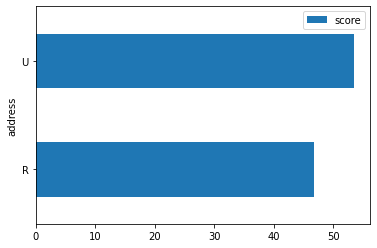

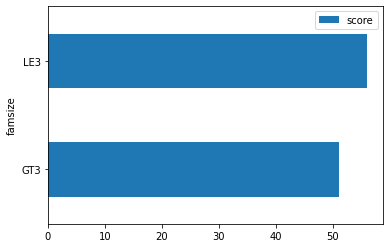

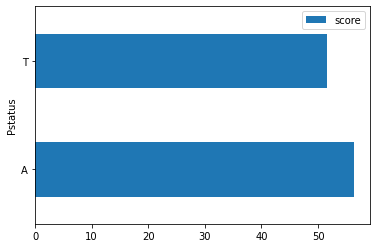

In [861]:
schMean = stud.filter(items=['school','score']).groupby(by = ['school']).mean().plot(kind = 'barh')
addMean = stud.filter(items=['address','score']).groupby(by = ['address']).mean().plot(kind = 'barh')
famMean = stud.filter(items=['famsize','score']).groupby(by = ['famsize']).mean().plot(kind = 'barh')
pstMean = stud.filter(items=['Pstatus','score']).groupby(by = ['Pstatus']).mean().plot(kind = 'barh')

print('\nНиже представлены графики некоторых условий жизни учеников которые влияют на их средние оценки. A конкретно то что средние баллы выше у тех учеников которые учатся или учились в школе GP, находятся в городе, семья состоит из менее или равно 3 чел. и родители находятся в разводе.\n\n')


В след. графиках можно заметить что у тех учеников родители которых не работают низкие в среднем оценки.




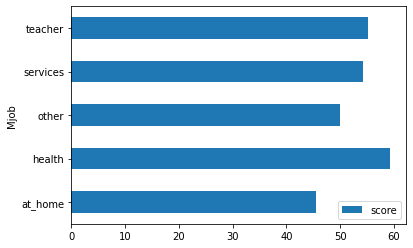

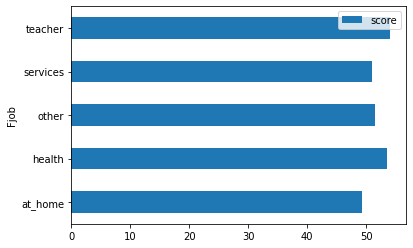

In [864]:
MjobMean = stud.filter(items=['Mjob','score']).groupby(by = ['Mjob']).mean().plot(kind = 'barh')
FjobMean = stud.filter(items=['Fjob','score']).groupby(by = ['Fjob']).mean().plot(kind = 'barh')

print('\nВ след. графиках можно заметить что у тех учеников родители которых не работают в среднем оценки ниже.\n\n')

traveltime  studytime  failures    famrel  freetime     goout  \
traveltime    1.000000  -0.109333  0.083311 -0.051752  0.009835  0.004574   
studytime    -0.109333   1.000000 -0.143829  0.018273 -0.141048 -0.048134   
failures      0.083311  -0.143829  1.000000  0.031704  0.117818  0.084852   
famrel       -0.051752   0.018273  0.031704  1.000000  0.169739  0.092249   
freetime      0.009835  -0.141048  0.117818  0.169739  1.000000  0.283708   
goout         0.004574  -0.048134  0.084852  0.092249  0.283708  1.000000   
health       -0.011856  -0.102211  0.067415  0.096186  0.074485 -0.008117   
absences     -0.053176  -0.069378  0.059202 -0.061762  0.100271  0.061950   
score        -0.067642   0.119395 -0.311995  0.045598  0.042375 -0.127803   

              health  absences     score  
traveltime -0.011856 -0.053176 -0.067642  
studytime  -0.102211 -0.069378  0.119395  
failures    0.067415  0.059202 -0.311995  
famrel      0.096186 -0.061762  0.045598  
freetime    0.074485  0.100271  0.042375  
goout      -0.008117  0.061950 -0.127803  
health      1.000000 -0.003061 -0.046172  
absences   -0.003061  1.000000  0.107494  
score      -0.046172  0.107494  1.000000


Ниже приведен очень тяжелый график корреляций, но из всех графиков нам интересен лишь тот который находится на последней строке. Где можно увидить какие показатели сильнее влияют на оценки а какие не очень.
traveltime - влияет не сильно, но есть тенденция что чем дольше ученик добирается до школы тем хуже оценки.
studytime - тут немного заметно что чем больше ученик проводит внеучебное время за учебой то оценки выше.
failures - тут самое интересное, очень наглядный показатель того что жизненные неудачи могут влиять на успешность ребенка в том числе и на учебе.
famrel и freetime - оба показателя показывают не значительное влияние на оценки
goout - этот показатель указывает на то что если ребенок больше проводит время со своими друзьями то оценки снижаются
health и absences - очень удивили эти показатели, по ним можно узнать что если у ученика было плохое самочуствие и если он больше пропускал уроки то оценки были выше.¯\_(ツ)_/¯




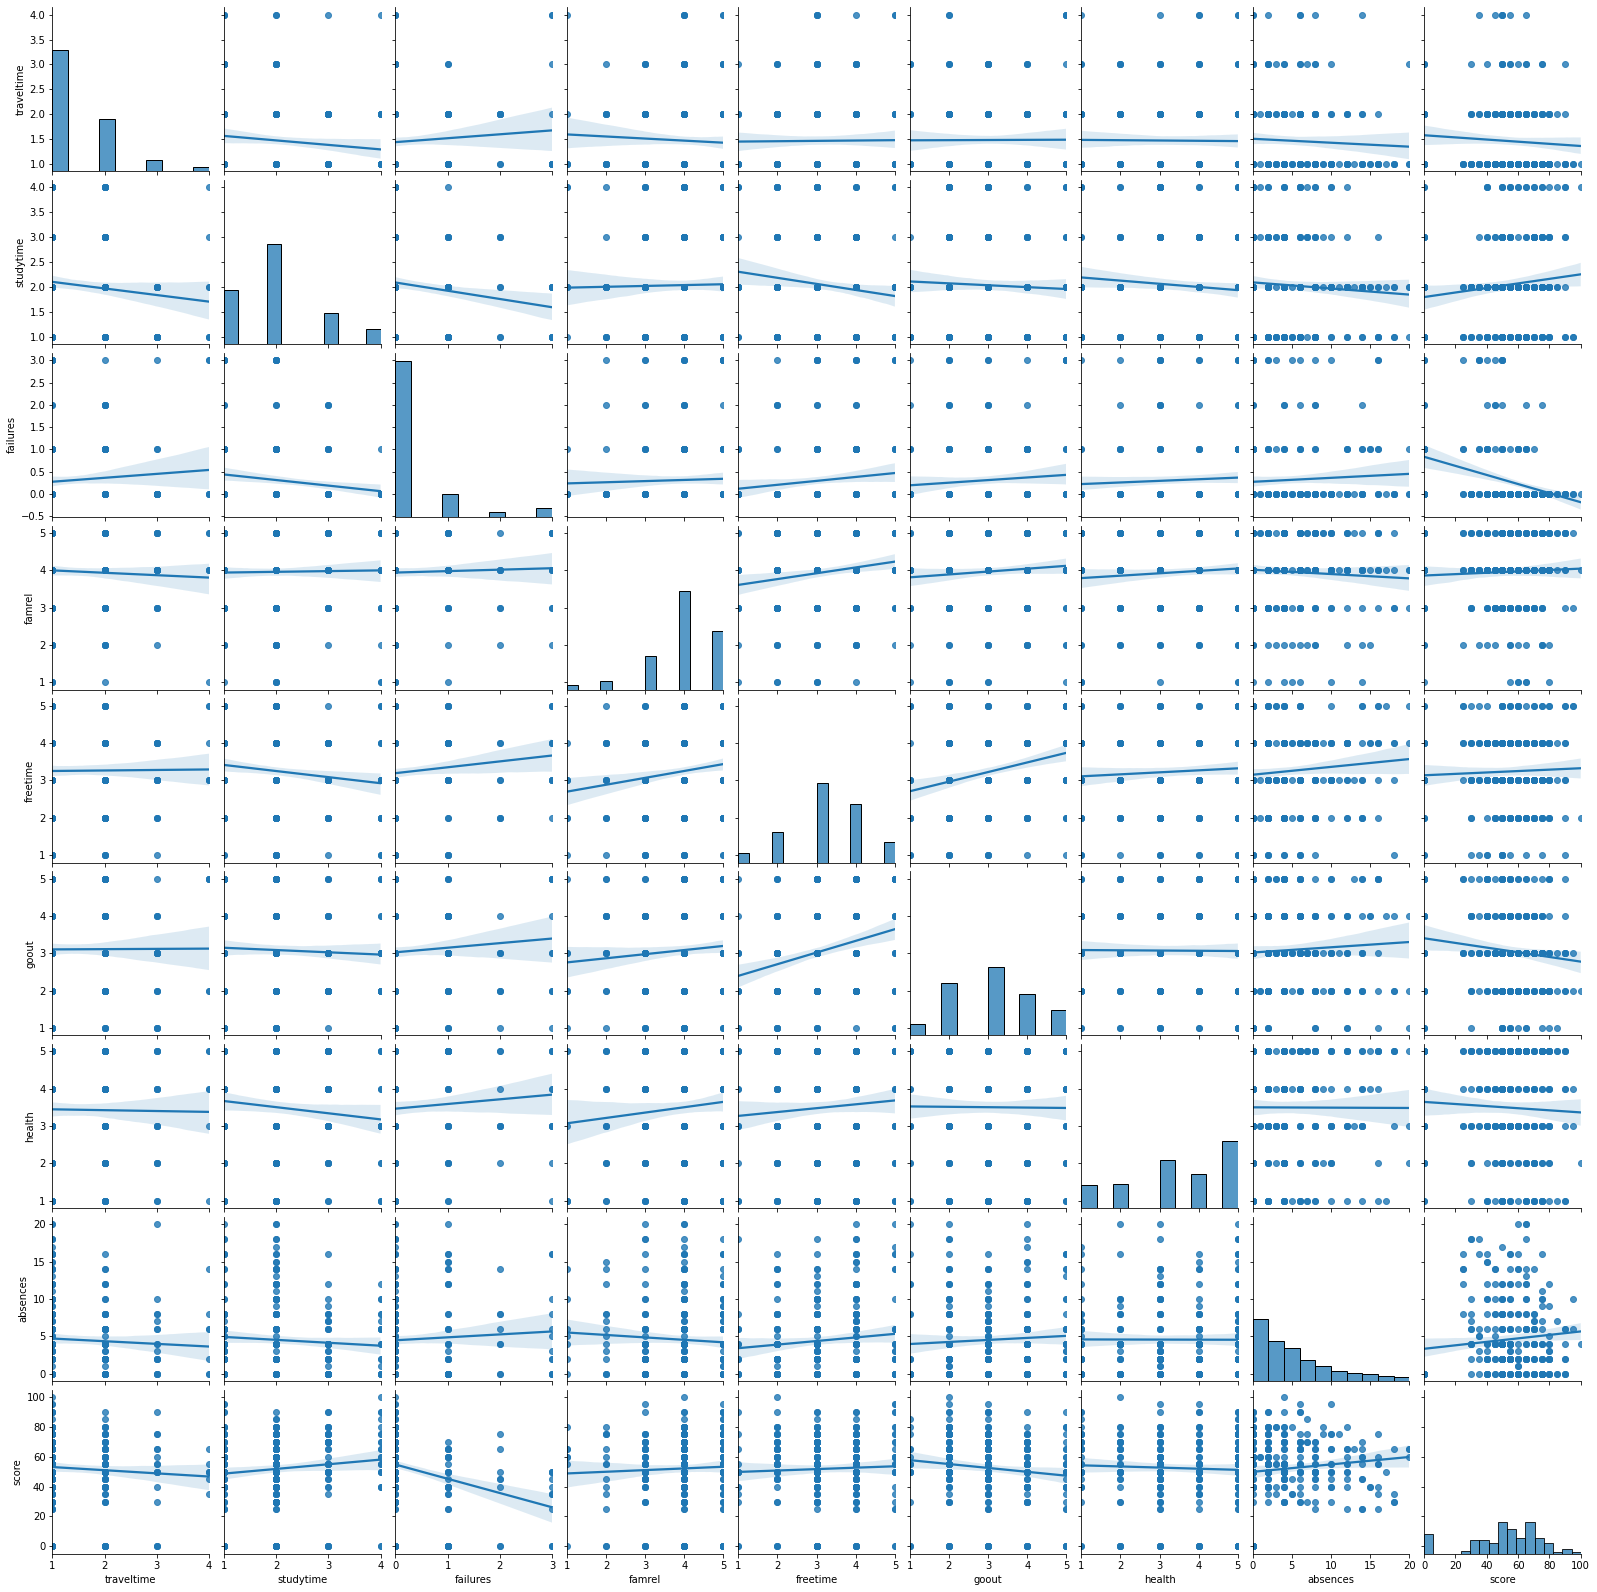

In [871]:
corrDf = pd.DataFrame([stud.traveltime, stud.studytime, stud.failures, stud.famrel, stud.freetime, stud.goout, stud.health, stud.absences, stud.score]).transpose()
display(corrDf.corr())
display(sns.pairplot(corrDf, kind='reg'))

print('\nНиже приведен очень тяжелый график корреляций, но из всех графиков нам интересен лишь тот который находится на последней строке. Где можно увидить какие показатели сильнее влияют на оценки а какие не очень.\ntraveltime - влияет не сильно, но есть тенденция что чем дольше ученик добирается до школы тем хуже оценки.\nstudytime - тут немного заметно что чем больше ученик проводит внеучебное время за учебой то оценки выше.\nfailures - тут самое интересное, очень наглядный показатель того что жизненные неудачи могут влиять на успешность ребенка в том числе и на учебе.\nfamrel и freetime - оба показателя показывают не значительное влияние на оценки\ngoout - этот показатель указывает на то что если ребенок больше проводит время со своими друзьями то оценки снижаются\nhealth и absences - очень удивили эти показатели, по ним можно узнать что если у ученика было плохое самочуствие и если он больше пропускал уроки то оценки были выше.¯\_(ツ)_/¯\n\n')

In [631]:
stud.head(10)

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0      GP   F   18       U    None       A   4.0   4.0   at_home  teacher   
1      GP   F   17       U     GT3    None   1.0   1.0   at_home    other   
2      GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3      GP   F   15       U     GT3       T   4.0   2.0    health     None   
4      GP   F   16       U     GT3       T   3.0   3.0     other    other   
5      GP   M   16       U     LE3       T   4.0   3.0  services    other   
6      GP   M   16    None     LE3       T   2.0   2.0     other    other   
7      GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
9      GP   M   15       U    None    None   3.0   4.0     other    other   
10     GP   F   15       U     GT3       T   4.0   4.0   teacher   health   

        reason guardian  traveltime  studytime  failures schoolsup famsup  \
0       course   mother         2.0        2.0       0.0       yes     no   
1       course   father         1.0        2.0       0.0        no    yes   
2        other   mother         1.0        2.0       3.0       yes     no   
3         home   mother         1.0        3.0       0.0        no    yes   
4         home   father         1.0        2.0       0.0        no    yes   
5   reputation   mother         1.0        2.0       0.0        no    yes   
6         home   mother         1.0        2.0       0.0        no     no   
7         home   mother         2.0        2.0       0.0       yes    yes   
9         home   mother         1.0        2.0       0.0        no    yes   
10  reputation   mother         1.0        2.0       0.0        no    yes   

    paid activities nursery  studytime_granular higher internet romantic  \
0     no         no     yes                -6.0    yes     None       no   
1     no         no      no                -6.0    yes      yes       no   
2   None         no     yes                -6.0    yes      yes     None   
3    yes        yes     yes                -9.0    yes      yes      yes   
4    yes         no     yes                -6.0    yes       no       no   
5    yes        yes     yes                -6.0    yes      yes       no   
6     no         no     yes                -6.0    yes      yes       no   
7     no         no     yes                -6.0    yes       no       no   
9    yes        yes     yes                -6.0    yes      yes       no   
10   yes         no     yes                -6.0    yes      yes       no   

    famrel  freetime  goout  health  absences  score  
0      4.0       3.0    4.0     3.0       6.0   30.0  
1      5.0       3.0    3.0     3.0       4.0   30.0  
2      4.0       3.0    2.0     3.0      10.0   50.0  
3      3.0       2.0    2.0     5.0       2.0   75.0  
4      4.0       3.0    2.0     5.0       4.0   50.0  
5      5.0       4.0    2.0     5.0      10.0   75.0  
6      4.0       4.0    4.0     3.0       0.0   55.0  
7      4.0       1.0    4.0     1.0       6.0   30.0  
9      5.0       5.0    1.0     5.0       0.0   75.0  
10     3.0       3.0    3.0     2.0       0.0   45.0